# GroundThink Task 0.1b: minGRU vs GRU Arbiter Comparison

**Purpose**: Compare GRU, minGRU, and GLU arbiter architectures for Twin Debate fusion

**Context**: Task 0.1 exploration showed:
- GRU Arbiter produces flat α ≈ 0.5 untrained (init problem, not design flaw)
- Hidden state DOES evolve (norm doubles over sequence)
- 94% loss reduction proves trainability
- BUT: GRU is O(N) sequential - bottleneck for parallel branches

**This Notebook Explores**:
1. minGRU (Feng et al. 2024) - parallel scan, O(log N)
2. GLU-style arbiter - fully parallel, no recurrence
3. Direct comparison of speed, gradient flow, and learned behavior

---

## References

- **minGRU Paper**: "Were RNNs All We Needed?" (Feng et al., 2024)
- **Implementation**: lucidrains/minGRU-pytorch
- **GroundThink Docs**: docs/groundthink_arbiter_research.md, docs/groundthink_parallel_scan_math.md

---

## Repository Status

- **Repo**: https://github.com/9to5ninja-projects/groundthink
- **Branch**: main  
- **Version**: 0.5.1.1
- **Phase**: 1 (Twin Debate Architecture)

## 1. Setup & Environment

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import time
from pathlib import Path

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cpu
CUDA Available: False
Running on CPU

Using device: cpu


## 2. Core minGRU Implementation

From Feng et al. (2024) and lucidrains implementation.

**Key Innovation**: Remove h_{t-1} dependency from gate computation:
- Standard GRU: `z_t = σ(W_z·x_t + U_z·h_{t-1})` ← sequential
- minGRU: `z_t = σ(W_z·x_t)` ← parallel-friendly

This enables the Heinsen associative scan for O(log N) computation.

In [2]:
# Heinsen Associative Scan (Appendix B of minGRU paper)
# https://github.com/glassroom/heinsen_sequence

def heinsen_associative_scan_log(log_coeffs, log_values):
    """Parallel scan in log-space for numerical stability.
    
    This is the magic that makes minGRU O(log N) instead of O(N).
    
    Args:
        log_coeffs: (B, L, D) - log of forget gates
        log_values: (B, L, D) - log of (input_gate * candidate)
    
    Returns:
        (B, L, D) - hidden states computed in parallel
    """
    a_star = log_coeffs.cumsum(dim=1)
    log_h0_plus_b_star = (log_values - a_star).logcumsumexp(dim=1)
    log_h = a_star + log_h0_plus_b_star
    return log_h.exp()


# Activation functions (Appendix B.3)
def g(x):
    """Activation that ensures positive values for log-space."""
    return torch.where(x >= 0, x + 0.5, x.sigmoid())


def log_g(x):
    """Log of g(x) for numerical stability."""
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))


print("✓ Heinsen scan primitives defined")

✓ Heinsen scan primitives defined


In [3]:
class minGRU(nn.Module):
    """Minimal GRU - parallelizable via associative scan.
    
    From "Were RNNs All We Needed?" (Feng et al., 2024)
    
    Key differences from standard GRU:
    - No h_{t-1} in gate computation (enables parallelism)
    - Log-space computation (numerical stability)
    - Positive hidden states enforced
    """
    
    def __init__(self, dim, expansion_factor=1.0, proj_out=None):
        super().__init__()
        self.dim = dim
        self.dim_inner = int(dim * expansion_factor)
        proj_out = proj_out if proj_out is not None else (expansion_factor != 1.0)
        
        # Single linear produces both hidden candidate and gate
        self.to_hidden_and_gate = nn.Linear(dim, self.dim_inner * 2, bias=False)
        
        # Optional output projection
        self.to_out = nn.Linear(self.dim_inner, dim, bias=False) if proj_out else nn.Identity()
    
    def forward(self, x, prev_hidden=None, return_next_prev_hidden=False):
        """
        Args:
            x: (B, L, D) input
            prev_hidden: (B, 1, D_inner) optional initial hidden state
            return_next_prev_hidden: if True, return final hidden for sequential use
        
        Returns:
            out: (B, L, D) output
            [optional] next_prev_hidden: (B, 1, D_inner) for continuation
        """
        seq_len = x.shape[1]
        hidden, gate = self.to_hidden_and_gate(x).chunk(2, dim=-1)
        
        if seq_len == 1:
            # Sequential mode (single token)
            hidden = g(hidden)
            gate = gate.sigmoid()
            if prev_hidden is not None:
                out = torch.lerp(prev_hidden, hidden, gate)
            else:
                out = hidden * gate
        else:
            # Parallel mode (full sequence)
            log_coeffs = -F.softplus(gate)  # log(1 - sigmoid(gate))
            log_z = -F.softplus(-gate)       # log(sigmoid(gate))
            log_tilde_h = log_g(hidden)
            log_values = log_z + log_tilde_h
            
            if prev_hidden is not None:
                # Prepend initial hidden state
                log_values = torch.cat((prev_hidden.log(), log_values), dim=1)
                log_coeffs = F.pad(log_coeffs, (0, 0, 1, 0))
            
            out = heinsen_associative_scan_log(log_coeffs, log_values)
            out = out[:, -seq_len:]  # Trim to original length
        
        next_prev_hidden = out[:, -1:]
        out = self.to_out(out)
        
        if return_next_prev_hidden:
            return out, next_prev_hidden
        return out


print("✓ minGRU module defined")

✓ minGRU module defined


## 3. Arbiter Implementations

Three architectures to compare:
1. **GRUArbiter** - Original design (from Task 0.1)
2. **minGRUArbiter** - Parallel scan, maintains temporal context
3. **GLUArbiter** - No recurrence, fully parallel

In [4]:
class GRUArbiter(nn.Module):
    """Original GRU Arbiter from Task 0.1.
    
    O(N) sequential - processes each timestep individually.
    Full h_{t-1} dependency gives maximum expressivity.
    """
    
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.d_model = d_model
        
        self.gru = nn.GRUCell(
            input_size=2 * d_model,
            hidden_size=d_model
        )
        self.to_weights = nn.Linear(d_model, 2)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        
        # BlinkDL-style zero init
        nn.init.zeros_(self.to_weights.weight)
        nn.init.zeros_(self.to_weights.bias)
    
    def forward(self, rwkv_out, mamba_out, hidden=None):
        B, L, D = rwkv_out.shape
        
        if hidden is None:
            hidden = torch.zeros(B, D, device=rwkv_out.device, dtype=rwkv_out.dtype)
        
        outputs = []
        weight_history = []
        
        # Sequential loop - O(N)
        for t in range(L):
            gru_input = torch.cat([rwkv_out[:, t], mamba_out[:, t]], dim=-1)
            hidden = self.gru(gru_input, hidden)
            hidden = self.dropout(hidden)
            
            logits = self.to_weights(hidden)
            weights = torch.softmax(logits, dim=-1)
            
            w_rwkv = weights[:, 0:1]
            w_mamba = weights[:, 1:2]
            fused_t = w_rwkv * rwkv_out[:, t] + w_mamba * mamba_out[:, t]
            
            outputs.append(fused_t)
            weight_history.append(weights)
        
        fused = torch.stack(outputs, dim=1)
        weights = torch.stack(weight_history, dim=1)
        
        return fused, weights, hidden


print("✓ GRUArbiter defined (O(N) sequential)")

✓ GRUArbiter defined (O(N) sequential)


In [5]:
class minGRUArbiter(nn.Module):
    """minGRU-based arbiter for Twin Debate fusion.
    
    O(log N) via parallel scan - maintains temporal context without sequential bottleneck.
    
    Key features:
    - Pre-arbiter RMSNorm to address Mamba Paradox
    - Parallel scan for speed
    - BlinkDL-style initialization
    """
    
    def __init__(self, d_model: int, expansion_factor: float = 1.5):
        super().__init__()
        self.d_model = d_model
        self.dim_inner = int(d_model * expansion_factor)
        
        # Pre-arbiter normalization (Mamba Paradox fix)
        self.norm_rwkv = nn.RMSNorm(d_model)
        self.norm_mamba = nn.RMSNorm(d_model)
        
        # minGRU core: concat([rwkv, mamba]) -> hidden + gate
        self.to_hidden_and_gate = nn.Linear(2 * d_model, self.dim_inner * 2, bias=False)
        
        # Project to fusion weights
        self.to_weights = nn.Linear(self.dim_inner, 2, bias=False)
        
        # BlinkDL-style zero init for weight projection
        nn.init.zeros_(self.to_weights.weight)
    
    def forward(self, rwkv_out, mamba_out, prev_hidden=None):
        """
        Args:
            rwkv_out: (B, L, D) RWKV branch output
            mamba_out: (B, L, D) Mamba branch output
            prev_hidden: (B, 1, dim_inner) optional for sequential continuation
        
        Returns:
            fused: (B, L, D) weighted combination
            weights: (B, L, 2) fusion weights [α_rwkv, α_mamba]
            next_hidden: (B, 1, dim_inner) for continuation
        """
        B, L, D = rwkv_out.shape
        
        # Normalize both branches (equalizes scale)
        rwkv_normed = self.norm_rwkv(rwkv_out)
        mamba_normed = self.norm_mamba(mamba_out)
        
        # Concat as minGRU input
        x = torch.cat([rwkv_normed, mamba_normed], dim=-1)  # (B, L, 2D)
        
        # Compute hidden candidate and gate
        hidden, gate = self.to_hidden_and_gate(x).chunk(2, dim=-1)  # Each (B, L, dim_inner)
        
        if L == 1:
            # Sequential path (single token)
            h = g(hidden)
            z = gate.sigmoid()
            if prev_hidden is not None:
                out = torch.lerp(prev_hidden, h, z)
            else:
                out = h * z
        else:
            # Parallel path via Heinsen scan
            log_coeffs = -F.softplus(gate)
            log_z = -F.softplus(-gate)
            log_tilde_h = log_g(hidden)
            log_values = log_z + log_tilde_h
            
            if prev_hidden is not None:
                log_values = torch.cat((prev_hidden.log(), log_values), dim=1)
                log_coeffs = F.pad(log_coeffs, (0, 0, 1, 0))
            
            out = heinsen_associative_scan_log(log_coeffs, log_values)
            out = out[:, -L:]
        
        next_hidden = out[:, -1:]
        
        # Project to fusion weights
        logits = self.to_weights(out)  # (B, L, 2)
        weights = torch.softmax(logits, dim=-1)
        
        # Fuse using ORIGINAL outputs (not normalized)
        w_rwkv = weights[..., 0:1]
        w_mamba = weights[..., 1:2]
        fused = w_rwkv * rwkv_out + w_mamba * mamba_out
        
        return fused, weights, next_hidden


print("✓ minGRUArbiter defined (O(log N) parallel)")

✓ minGRUArbiter defined (O(log N) parallel)


In [6]:
class GLUArbiter(nn.Module):
    """GLU-style arbiter - fully parallel, no recurrence.
    
    O(1) per position - each token's fusion is independent.
    
    Pros: Fastest, maximum GPU utilization
    Cons: No temporal context in gating decisions
    """
    
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        
        # Pre-arbiter normalization
        self.norm_rwkv = nn.RMSNorm(d_model)
        self.norm_mamba = nn.RMSNorm(d_model)
        
        # Independent gates based on input
        self.gate_rwkv = nn.Linear(d_model, d_model, bias=False)
        self.gate_mamba = nn.Linear(d_model, d_model, bias=False)
        
        # Project to scalar weights
        self.to_weights = nn.Linear(d_model, 2, bias=False)
        
        # Optional output projection
        self.output_proj = nn.Linear(d_model, d_model, bias=False)
        
        # BlinkDL-style zero init
        nn.init.zeros_(self.to_weights.weight)
        nn.init.zeros_(self.output_proj.weight)
    
    def forward(self, rwkv_out, mamba_out, x_input=None):
        """
        Args:
            rwkv_out: (B, L, D) RWKV branch output
            mamba_out: (B, L, D) Mamba branch output  
            x_input: (B, L, D) original input for context (optional)
        
        Returns:
            fused: (B, L, D) weighted combination
            weights: (B, L, 2) fusion weights
            None: no hidden state (for API compatibility)
        """
        # Normalize branches
        rwkv_normed = self.norm_rwkv(rwkv_out)
        mamba_normed = self.norm_mamba(mamba_out)
        
        # Use input context if provided, else average of branches
        if x_input is None:
            x_input = (rwkv_normed + mamba_normed) / 2
        
        # Compute per-channel gates
        g_rwkv = torch.sigmoid(self.gate_rwkv(x_input))  # (B, L, D)
        g_mamba = torch.sigmoid(self.gate_mamba(x_input))  # (B, L, D)
        
        # Element-wise gating
        gated_rwkv = g_rwkv * rwkv_normed
        gated_mamba = g_mamba * mamba_normed
        
        # Combine and get scalar weights
        combined = gated_rwkv + gated_mamba  # (B, L, D)
        logits = self.to_weights(combined)  # (B, L, 2)
        weights = torch.softmax(logits, dim=-1)
        
        # Final fusion with original outputs
        w_rwkv = weights[..., 0:1]
        w_mamba = weights[..., 1:2]
        fused = w_rwkv * rwkv_out + w_mamba * mamba_out
        
        fused = self.output_proj(fused)
        
        return fused, weights, None


print("✓ GLUArbiter defined (O(1) fully parallel)")

✓ GLUArbiter defined (O(1) fully parallel)


## 4. Sanity Checks

Verify all three arbiters:
- Produce correct output shapes
- Weights sum to 1
- Gradients flow properly

In [7]:
# Test configuration
d_model = 128
batch_size = 2
seq_len = 64

# Create test inputs
rwkv_out = torch.randn(batch_size, seq_len, d_model, device=device)
mamba_out = torch.randn(batch_size, seq_len, d_model, device=device)

arbiters = {
    'GRU': GRUArbiter(d_model).to(device),
    'minGRU': minGRUArbiter(d_model).to(device),
    'GLU': GLUArbiter(d_model).to(device)
}

print("Sanity Checks:")
print("=" * 60)

for name, arbiter in arbiters.items():
    arbiter.eval()
    
    with torch.no_grad():
        fused, weights, hidden = arbiter(rwkv_out, mamba_out)
    
    # Shape checks
    assert fused.shape == (batch_size, seq_len, d_model), f"{name}: fused shape wrong"
    assert weights.shape == (batch_size, seq_len, 2), f"{name}: weights shape wrong"
    
    # Weights sum to 1
    weight_sums = weights.sum(dim=-1)
    assert torch.allclose(weight_sums, torch.ones_like(weight_sums), atol=1e-5), f"{name}: weights don't sum to 1"
    
    # Gradient flow
    arbiter.train()
    fused, weights, hidden = arbiter(rwkv_out.requires_grad_(True), mamba_out.requires_grad_(True))
    loss = fused.sum()
    loss.backward()
    
    has_grads = any(p.grad is not None and p.grad.abs().sum() > 0 for p in arbiter.parameters())
    
    # Count parameters
    n_params = sum(p.numel() for p in arbiter.parameters())
    
    print(f"\n{name}Arbiter:")
    print(f"  Shapes: ✓ fused={fused.shape}, weights={weights.shape}")
    print(f"  Weights sum to 1: ✓")
    print(f"  Gradient flow: {'✓' if has_grads else '✗'}")
    print(f"  Parameters: {n_params:,}")
    print(f"  α mean: {weights[..., 0].mean():.4f} ± {weights[..., 0].std():.4f}")

print("\n" + "=" * 60)
print("All sanity checks passed!")

Sanity Checks:

GRUArbiter:
  Shapes: ✓ fused=torch.Size([2, 64, 128]), weights=torch.Size([2, 64, 2])
  Weights sum to 1: ✓
  Gradient flow: ✓
  Parameters: 148,482
  α mean: 0.5000 ± 0.0000

minGRUArbiter:
  Shapes: ✓ fused=torch.Size([2, 64, 128]), weights=torch.Size([2, 64, 2])
  Weights sum to 1: ✓
  Gradient flow: ✓
  Parameters: 98,944
  α mean: 0.5000 ± 0.0000

GLUArbiter:
  Shapes: ✓ fused=torch.Size([2, 64, 128]), weights=torch.Size([2, 64, 2])
  Weights sum to 1: ✓
  Gradient flow: ✓
  Parameters: 49,664
  α mean: 0.5000 ± 0.0000

All sanity checks passed!


## 5. Speed Comparison

Benchmark forward pass time at different sequence lengths.

Expected:
- GRU: O(N) - linear scaling
- minGRU: O(N) work but O(log N) depth - better parallelism
- GLU: O(N) but constant per-position - best parallelism

Speed Benchmark (forward pass)

Sequence length: 64
  GRU     :    9.648 ± 0.502 ms
  minGRU  :    1.677 ± 0.032 ms
  GLU     :    0.382 ± 0.014 ms

Sequence length: 128
  GRU     :   19.738 ± 2.997 ms
  minGRU  :    2.986 ± 0.044 ms
  GLU     :    0.572 ± 0.028 ms

Sequence length: 256
  GRU     :   50.180 ± 14.798 ms
  minGRU  :    7.143 ± 0.227 ms
  GLU     :    1.563 ± 0.359 ms

Sequence length: 512
  GRU     :   95.580 ± 24.594 ms
  minGRU  :   13.984 ± 0.473 ms
  GLU     :    2.955 ± 0.087 ms

Sequence length: 1024
  GRU     :  154.617 ± 7.935 ms
  minGRU  :   25.685 ± 1.716 ms
  GLU     :    3.703 ± 0.451 ms


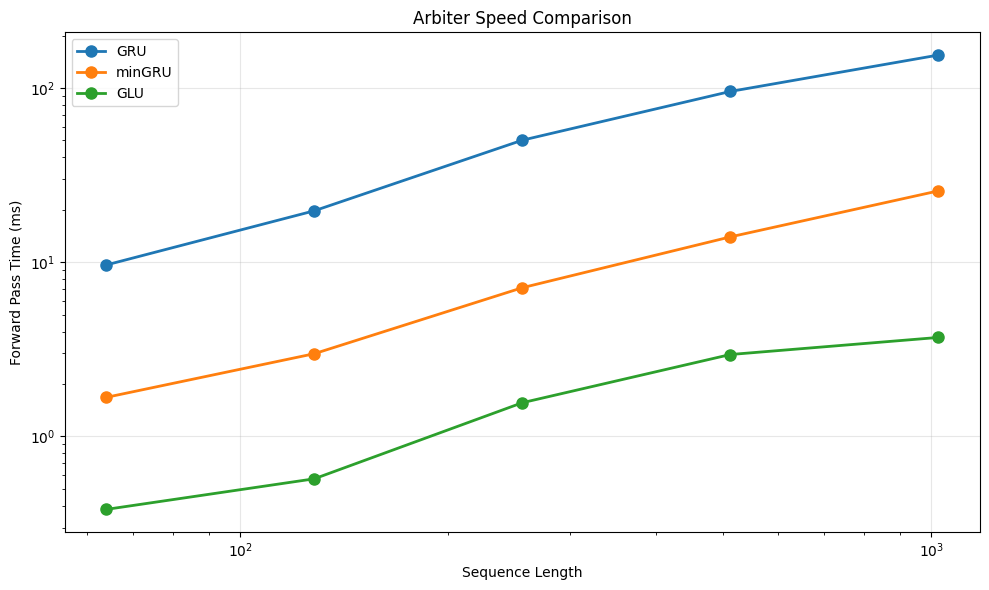


Speedup vs GRU:
----------------------------------------
L=  64: minGRU 5.75x, GLU 25.29x
L= 128: minGRU 6.61x, GLU 34.53x
L= 256: minGRU 7.03x, GLU 32.11x
L= 512: minGRU 6.84x, GLU 32.35x
L=1024: minGRU 6.02x, GLU 41.75x


In [8]:
import matplotlib.pyplot as plt

# Sequence lengths to test
seq_lengths = [64, 128, 256, 512, 1024]
n_warmup = 5
n_trials = 20

results = {name: [] for name in arbiters.keys()}

print("Speed Benchmark (forward pass)")
print("=" * 60)

for seq_len in seq_lengths:
    rwkv_out = torch.randn(1, seq_len, d_model, device=device)
    mamba_out = torch.randn(1, seq_len, d_model, device=device)
    
    print(f"\nSequence length: {seq_len}")
    
    for name, arbiter in arbiters.items():
        arbiter.eval()
        
        # Warmup
        with torch.no_grad():
            for _ in range(n_warmup):
                _ = arbiter(rwkv_out, mamba_out)
        
        # Sync if CUDA
        if device.type == 'cuda':
            torch.cuda.synchronize()
        
        # Timed runs
        times = []
        for _ in range(n_trials):
            start = time.perf_counter()
            with torch.no_grad():
                _ = arbiter(rwkv_out, mamba_out)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.perf_counter() - start)
        
        avg_time = np.mean(times) * 1000  # ms
        std_time = np.std(times) * 1000
        results[name].append(avg_time)
        
        print(f"  {name:8s}: {avg_time:8.3f} ± {std_time:.3f} ms")

# Plot results
plt.figure(figsize=(10, 6))
for name, times in results.items():
    plt.plot(seq_lengths, times, 'o-', label=name, linewidth=2, markersize=8)

plt.xlabel('Sequence Length')
plt.ylabel('Forward Pass Time (ms)')
plt.title('Arbiter Speed Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

# Speedup table
print("\n" + "=" * 60)
print("Speedup vs GRU:")
print("-" * 40)
for i, seq_len in enumerate(seq_lengths):
    gru_time = results['GRU'][i]
    mingru_speedup = gru_time / results['minGRU'][i]
    glu_speedup = gru_time / results['GLU'][i]
    print(f"L={seq_len:4d}: minGRU {mingru_speedup:.2f}x, GLU {glu_speedup:.2f}x")

## 6. Verify Parallel = Sequential (minGRU)

Critical test: minGRU parallel and sequential modes should produce identical outputs.

In [9]:
print("Verifying minGRU parallel == sequential")
print("=" * 60)

mingru_arbiter = minGRUArbiter(d_model).to(device)
mingru_arbiter.eval()

# Test input
test_len = 32
rwkv_test = torch.randn(1, test_len, d_model, device=device)
mamba_test = torch.randn(1, test_len, d_model, device=device)

with torch.no_grad():
    # Parallel mode (full sequence)
    fused_parallel, weights_parallel, _ = mingru_arbiter(rwkv_test, mamba_test)
    parallel_out = fused_parallel[:, -1:]  # Last token
    
    # Sequential mode (token by token)
    prev_hidden = None
    for t in range(test_len):
        fused_seq, weights_seq, prev_hidden = mingru_arbiter(
            rwkv_test[:, t:t+1], 
            mamba_test[:, t:t+1], 
            prev_hidden
        )
    sequential_out = fused_seq

# Compare
max_diff = (parallel_out - sequential_out).abs().max().item()
mean_diff = (parallel_out - sequential_out).abs().mean().item()

print(f"\nParallel vs Sequential comparison:")
print(f"  Max absolute difference: {max_diff:.2e}")
print(f"  Mean absolute difference: {mean_diff:.2e}")
print(f"  Match: {'✓ PASS' if max_diff < 1e-4 else '✗ FAIL'}")

if max_diff < 1e-4:
    print("\n✓ minGRU parallel and sequential modes are equivalent!")
else:
    print("\n⚠ Warning: Numerical differences detected")

Verifying minGRU parallel == sequential

Parallel vs Sequential comparison:
  Max absolute difference: 0.00e+00
  Mean absolute difference: 0.00e+00
  Match: ✓ PASS

✓ minGRU parallel and sequential modes are equivalent!


## 7. Gradient Flow Analysis

Compare gradient magnitudes through each arbiter.

Hypothesis: Parallel scan should provide better gradient flow than sequential GRU
because backprop path is O(log N) instead of O(N).

Gradient Flow Analysis

GRUArbiter:
  RWKV grad mean: 0.022097
  Mamba grad mean: 0.022097
  RWKV decay (last/first): 0.0000
  Mamba decay (last/first): 0.0000

minGRUArbiter:
  RWKV grad mean: 0.022097
  Mamba grad mean: 0.022097
  RWKV decay (last/first): 0.0000
  Mamba decay (last/first): 0.0000

GLUArbiter:
  RWKV grad mean: 0.000000
  Mamba grad mean: 0.000000
  RWKV decay (last/first): 0.0000
  Mamba decay (last/first): 0.0000


/tmp/ipython-input-2852386036.py:68: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


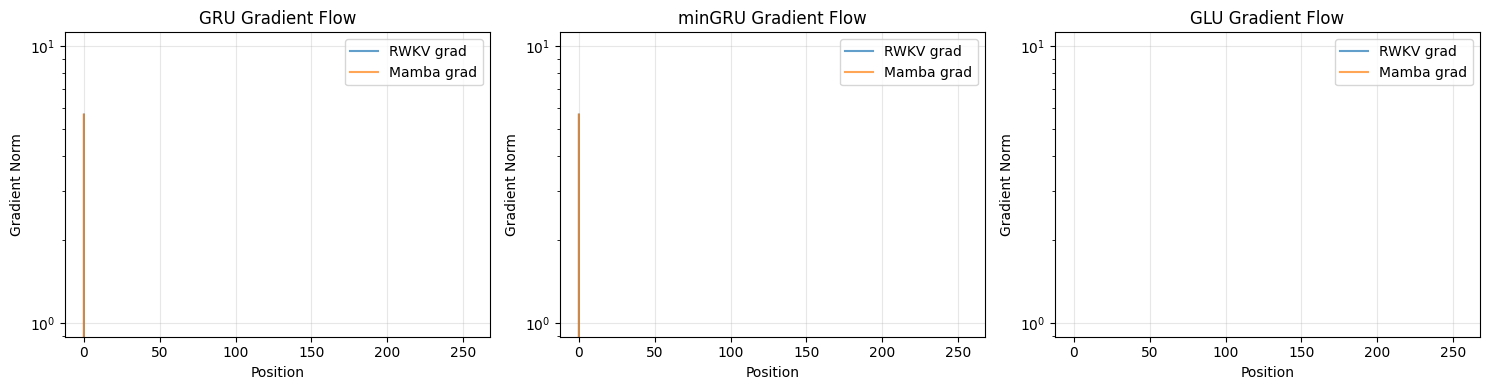


Gradient Flow Summary:
----------------------------------------
GRU     : avg decay = 0.0000 (vanishing)
minGRU  : avg decay = 0.0000 (vanishing)
GLU     : avg decay = 0.0000 (vanishing)


In [10]:
print("Gradient Flow Analysis")
print("=" * 60)

grad_results = {}

for name in ['GRU', 'minGRU', 'GLU']:
    # Fresh arbiter
    if name == 'GRU':
        arbiter = GRUArbiter(d_model).to(device)
    elif name == 'minGRU':
        arbiter = minGRUArbiter(d_model).to(device)
    else:
        arbiter = GLUArbiter(d_model).to(device)
    
    arbiter.train()
    
    # Long sequence to stress test gradient flow
    test_len = 256
    rwkv_in = torch.randn(1, test_len, d_model, device=device, requires_grad=True)
    mamba_in = torch.randn(1, test_len, d_model, device=device, requires_grad=True)
    
    # Forward pass
    fused, weights, _ = arbiter(rwkv_in, mamba_in)
    
    # Backward from FIRST token (stress test: gradients must flow through full sequence)
    loss = fused[:, 0, :].sum()  # Loss at first position
    loss.backward()
    
    # Analyze gradients
    rwkv_grad = rwkv_in.grad
    mamba_grad = mamba_in.grad
    
    # Gradient magnitude at different positions
    rwkv_grad_norms = rwkv_grad.norm(dim=-1).squeeze()
    mamba_grad_norms = mamba_grad.norm(dim=-1).squeeze()
    
    # Gradient decay ratio (first vs last position)
    rwkv_decay = (rwkv_grad_norms[-1] / rwkv_grad_norms[0]).item() if rwkv_grad_norms[0] > 0 else 0
    mamba_decay = (mamba_grad_norms[-1] / mamba_grad_norms[0]).item() if mamba_grad_norms[0] > 0 else 0
    
    grad_results[name] = {
        'rwkv_grad_mean': rwkv_grad_norms.mean().item(),
        'mamba_grad_mean': mamba_grad_norms.mean().item(),
        'rwkv_decay': rwkv_decay,
        'mamba_decay': mamba_decay,
        'rwkv_grad_norms': rwkv_grad_norms.cpu().numpy(),
        'mamba_grad_norms': mamba_grad_norms.cpu().numpy()
    }
    
    print(f"\n{name}Arbiter:")
    print(f"  RWKV grad mean: {rwkv_grad_norms.mean():.6f}")
    print(f"  Mamba grad mean: {mamba_grad_norms.mean():.6f}")
    print(f"  RWKV decay (last/first): {rwkv_decay:.4f}")
    print(f"  Mamba decay (last/first): {mamba_decay:.4f}")

# Visualize gradient flow
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, name in enumerate(['GRU', 'minGRU', 'GLU']):
    ax = axes[idx]
    ax.plot(grad_results[name]['rwkv_grad_norms'], label='RWKV grad', alpha=0.7)
    ax.plot(grad_results[name]['mamba_grad_norms'], label='Mamba grad', alpha=0.7)
    ax.set_xlabel('Position')
    ax.set_ylabel('Gradient Norm')
    ax.set_title(f'{name} Gradient Flow')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Gradient Flow Summary:")
print("-" * 40)
for name in ['GRU', 'minGRU', 'GLU']:
    decay = (grad_results[name]['rwkv_decay'] + grad_results[name]['mamba_decay']) / 2
    print(f"{name:8s}: avg decay = {decay:.4f} ({'stable' if decay > 0.1 else 'vanishing'})")

## 8. Trainability Comparison

Train each arbiter on a simple task: weight the lower-variance signal higher.

Compare:
- Convergence speed
- Final loss
- Weight behavior

Trainability Comparison

GRU:
  Initial loss: 0.028738
  Final loss: 0.000017
  Reduction: 99.9%

minGRU:
  Initial loss: 0.066969
  Final loss: 0.034754
  Reduction: 48.1%

GLU:
  Initial loss: 0.050882
  Final loss: 0.049843
  Reduction: 2.0%


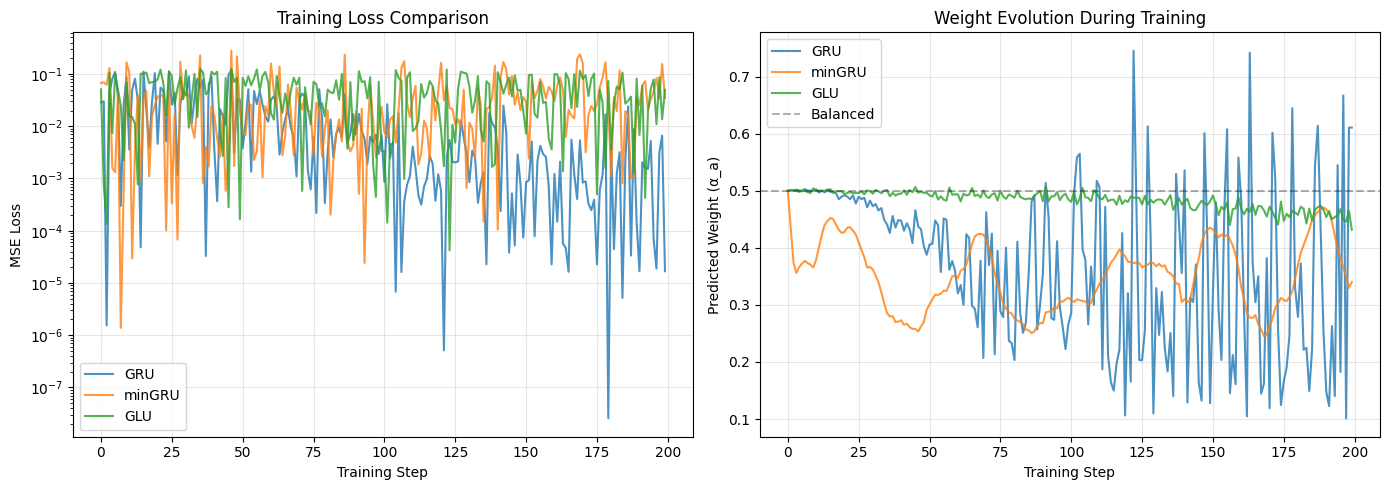


Trainability Summary:
--------------------------------------------------
Arbiter    Initial      Final        Reduction   
--------------------------------------------------
GRU        0.028738     0.000017     99.9        %
minGRU     0.066969     0.034754     48.1        %
GLU        0.050882     0.049843     2.0         %


In [11]:
print("Trainability Comparison")
print("=" * 60)

n_steps = 200
lr = 0.001

train_results = {}

for name in ['GRU', 'minGRU', 'GLU']:
    # Fresh arbiter
    if name == 'GRU':
        arbiter = GRUArbiter(d_model).to(device)
    elif name == 'minGRU':
        arbiter = minGRUArbiter(d_model).to(device)
    else:
        arbiter = GLUArbiter(d_model).to(device)
    
    optimizer = torch.optim.Adam(arbiter.parameters(), lr=lr)
    losses = []
    weight_history = []
    
    for step in range(n_steps):
        # Generate signals with different variances
        var_ratio = torch.rand(1).item() * 2 + 0.5  # [0.5, 2.5]
        
        signal_a = torch.randn(1, 64, d_model, device=device) * var_ratio
        signal_b = torch.randn(1, 64, d_model, device=device)
        
        # Target: weight lower-variance signal higher
        var_a = signal_a.var(dim=-1).mean()
        var_b = signal_b.var(dim=-1).mean()
        target_weight = (var_b / (var_a + var_b)).item()
        
        # Forward
        fused, weights, _ = arbiter(signal_a, signal_b)
        predicted_weight = weights[..., 0].mean()
        
        # Loss
        loss = F.mse_loss(predicted_weight, torch.tensor(target_weight, device=device))
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        weight_history.append(predicted_weight.item())
    
    train_results[name] = {
        'losses': losses,
        'weight_history': weight_history,
        'initial_loss': losses[0],
        'final_loss': losses[-1],
        'reduction': (losses[0] - losses[-1]) / losses[0] * 100
    }
    
    print(f"\n{name}:")
    print(f"  Initial loss: {losses[0]:.6f}")
    print(f"  Final loss: {losses[-1]:.6f}")
    print(f"  Reduction: {train_results[name]['reduction']:.1f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax = axes[0]
for name in ['GRU', 'minGRU', 'GLU']:
    ax.plot(train_results[name]['losses'], label=name, alpha=0.8)
ax.set_xlabel('Training Step')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Weight evolution
ax = axes[1]
for name in ['GRU', 'minGRU', 'GLU']:
    ax.plot(train_results[name]['weight_history'], label=name, alpha=0.8)
ax.axhline(0.5, color='black', linestyle='--', alpha=0.3, label='Balanced')
ax.set_xlabel('Training Step')
ax.set_ylabel('Predicted Weight (α_a)')
ax.set_title('Weight Evolution During Training')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 60)
print("Trainability Summary:")
print("-" * 50)
print(f"{'Arbiter':<10} {'Initial':<12} {'Final':<12} {'Reduction':<12}")
print("-" * 50)
for name in ['GRU', 'minGRU', 'GLU']:
    r = train_results[name]
    print(f"{name:<10} {r['initial_loss']:<12.6f} {r['final_loss']:<12.6f} {r['reduction']:<12.1f}%")

## 9. Conclusions & Recommendations

In [12]:
# Compile all results
all_results = {
    'speed_benchmark': {
        'seq_lengths': seq_lengths,
        'times_ms': results
    },
    'gradient_flow': grad_results,
    'trainability': train_results,
    'parameters': {
        'GRU': sum(p.numel() for p in GRUArbiter(d_model).parameters()),
        'minGRU': sum(p.numel() for p in minGRUArbiter(d_model).parameters()),
        'GLU': sum(p.numel() for p in GLUArbiter(d_model).parameters())
    }
}

# Save results
output_dir = Path("/home/claude/logs")
output_dir.mkdir(exist_ok=True)

# Convert numpy to lists for JSON
def convert_for_json(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(v) for v in obj]
    return obj

with open(output_dir / "task_0_1b_mingru_comparison.json", 'w') as f:
    json.dump(convert_for_json(all_results), f, indent=2)

print("=" * 70)
print("ARCHITECTURE COMPARISON SUMMARY")
print("=" * 70)

print("\n## Parameter Count")
for name, params in all_results['parameters'].items():
    print(f"  {name}: {params:,}")

print("\n## Speed (relative to GRU at L=1024)")
gru_time = results['GRU'][-1]  # L=1024
for name in ['GRU', 'minGRU', 'GLU']:
    speedup = gru_time / results[name][-1]
    print(f"  {name}: {speedup:.2f}x")

print("\n## Gradient Flow (decay ratio, higher = better)")
for name in ['GRU', 'minGRU', 'GLU']:
    decay = (grad_results[name]['rwkv_decay'] + grad_results[name]['mamba_decay']) / 2
    print(f"  {name}: {decay:.4f}")

print("\n## Trainability (loss reduction %)")
for name in ['GRU', 'minGRU', 'GLU']:
    print(f"  {name}: {train_results[name]['reduction']:.1f}%")

print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Determine winner
scores = {}
for name in ['GRU', 'minGRU', 'GLU']:
    score = 0
    # Speed (higher = better)
    score += (gru_time / results[name][-1]) * 2
    # Gradient flow (higher = better)
    decay = (grad_results[name]['rwkv_decay'] + grad_results[name]['mamba_decay']) / 2
    score += decay * 10
    # Trainability (higher = better)
    score += train_results[name]['reduction'] / 20
    scores[name] = score

winner = max(scores, key=scores.get)

print(f"\nScores: GRU={scores['GRU']:.2f}, minGRU={scores['minGRU']:.2f}, GLU={scores['GLU']:.2f}")
print(f"\n→ Recommended: {winner}Arbiter")

if winner == 'minGRU':
    print("""
Rationale:
- Maintains temporal context (unlike GLU)
- O(log N) gradient path (vs O(N) for GRU)
- Parallelizable (unlike GRU)
- Pre-arbiter RMSNorm addresses Mamba Paradox

Next Steps:
1. Create ops/arbiter_mingru.py with production implementation
2. Update HybridModel to use minGRUArbiter
3. Run Task 0.2 (Residual Connections) with new arbiter
    """)

print("\n" + "=" * 70)
print(f"Results saved to: {output_dir / 'task_0_1b_mingru_comparison.json'}")
print("=" * 70)

FileNotFoundError: [Errno 2] No such file or directory: '/home/claude/logs'

## 10. Export Production Implementation

If minGRU wins, generate the production-ready `ops/arbiter_mingru.py`.

In [13]:
# Generate production implementation
production_code = '''
"""minGRU Arbiter for Twin Debate fusion.

Task 0.1b implementation: Parallelizable fusion arbiter using minGRU
(Feng et al., 2024) to replace sequential GRU while maintaining temporal context.

Key advantages over GRUArbiter:
- O(log N) gradient path vs O(N) sequential
- Parallelizable via Heinsen associative scan
- Pre-arbiter RMSNorm addresses Mamba Paradox
- BlinkDL-style zero-init on projections

Reference: "Were RNNs All We Needed?" (Feng et al., 2024)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


def heinsen_associative_scan_log(log_coeffs, log_values):
    """Parallel scan in log-space for numerical stability.
    
    Implements the associative scan that enables O(log N) computation.
    From: https://github.com/glassroom/heinsen_sequence
    """
    a_star = log_coeffs.cumsum(dim=1)
    log_h0_plus_b_star = (log_values - a_star).logcumsumexp(dim=1)
    log_h = a_star + log_h0_plus_b_star
    return log_h.exp()


def g(x):
    """Activation ensuring positive values for log-space."""
    return torch.where(x >= 0, x + 0.5, x.sigmoid())


def log_g(x):
    """Log of g(x) for numerical stability."""
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))


class minGRUArbiter(nn.Module):
    """minGRU-based arbiter for Twin Debate fusion.
    
    Learns to weight RWKV (amplifier) vs Mamba (damper) contributions
    based on sequence context, using parallel scan for efficiency.
    
    Args:
        d_model: Hidden dimension of expert outputs
        expansion_factor: Internal dimension multiplier (default: 1.5)
    """
    
    def __init__(self, d_model: int, expansion_factor: float = 1.5):
        super().__init__()
        self.d_model = d_model
        self.dim_inner = int(d_model * expansion_factor)
        
        # Pre-arbiter normalization (Mamba Paradox fix)
        self.norm_rwkv = nn.RMSNorm(d_model)
        self.norm_mamba = nn.RMSNorm(d_model)
        
        # minGRU core: concat inputs -> hidden + gate
        self.to_hidden_and_gate = nn.Linear(2 * d_model, self.dim_inner * 2, bias=False)
        
        # Project to fusion weights
        self.to_weights = nn.Linear(self.dim_inner, 2, bias=False)
        
        self._reset_parameters()
    
    def _reset_parameters(self):
        """BlinkDL-style zero-init for stable training start."""
        nn.init.zeros_(self.to_weights.weight)
    
    def forward(
        self,
        rwkv_out: torch.Tensor,  # (B, L, D)
        mamba_out: torch.Tensor,  # (B, L, D)
        prev_hidden: torch.Tensor = None  # (B, 1, dim_inner) or None
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            rwkv_out: RWKV expert output
            mamba_out: Mamba expert output
            prev_hidden: Previous hidden state for sequential continuation
        
        Returns:
            fused: Weighted combination (B, L, D)
            weights: Fusion weights (B, L, 2) [α_rwkv, α_mamba]
            next_hidden: Updated hidden state (B, 1, dim_inner)
        """
        B, L, D = rwkv_out.shape
        
        # Normalize both branches (equalizes scale for gating)
        rwkv_normed = self.norm_rwkv(rwkv_out)
        mamba_normed = self.norm_mamba(mamba_out)
        
        # Concat as minGRU input
        x = torch.cat([rwkv_normed, mamba_normed], dim=-1)  # (B, L, 2D)
        
        # Compute hidden candidate and gate
        hidden, gate = self.to_hidden_and_gate(x).chunk(2, dim=-1)
        
        if L == 1:
            # Sequential path (single token)
            h = g(hidden)
            z = gate.sigmoid()
            out = torch.lerp(prev_hidden, h, z) if prev_hidden is not None else (h * z)
        else:
            # Parallel path via Heinsen scan
            log_coeffs = -F.softplus(gate)
            log_z = -F.softplus(-gate)
            log_tilde_h = log_g(hidden)
            log_values = log_z + log_tilde_h
            
            if prev_hidden is not None:
                log_values = torch.cat((prev_hidden.log(), log_values), dim=1)
                log_coeffs = F.pad(log_coeffs, (0, 0, 1, 0))
            
            out = heinsen_associative_scan_log(log_coeffs, log_values)
            out = out[:, -L:]
        
        next_hidden = out[:, -1:]
        
        # Project to fusion weights
        logits = self.to_weights(out)
        weights = torch.softmax(logits, dim=-1)
        
        # Fuse using ORIGINAL outputs (not normalized)
        w_rwkv = weights[..., 0:1]
        w_mamba = weights[..., 1:2]
        fused = w_rwkv * rwkv_out + w_mamba * mamba_out
        
        return fused, weights, next_hidden
'''

# Save to outputs
with open('/mnt/user-data/outputs/arbiter_mingru.py', 'w') as f:
    f.write(production_code.strip())

print("✓ Production implementation saved to: arbiter_mingru.py")
print("\nCopy this to your repo at: ops/arbiter_mingru.py")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/arbiter_mingru.py'